## Sheet07 Task 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


In [41]:
def correspondences(wx, wy, E, D, Gx, Gy):
    # w weights (pixel)
    # E edges binary
    # D distances
    # G gradient
    wn = np.stack((wy, wx), axis=0)
    gxgy = np.stack((Gy, Gx), axis=0)
    # with lecture formula
    x_n = wn - ( D / (np.sqrt(Gx**2 + Gy**2) + 1e-10) * gxgy)

    return x_n    


def compute_w(img):
    # construct the weights like in lecutre first in x dim then in y dim
    arr_x = []
    arr_y = []
    for i in range(img.shape[0]):
        arr_x.append(np.arange(0, img.shape[1], 1))
        arr_y.append(np.array([i] * img.shape[1]))
    wx = np.array(arr_x)
    wy = np.array(arr_y)
    return wx, wy
  
def compute_E(img):
    E = cv.Canny(img, 120, 120)
    return E

def compute_D(edges_binary):
    # computes distances from 0 values
    E_invert = cv.bitwise_not(edges_binary)
    D = cv.distanceTransform(E_invert.astype(np.uint8), distanceType=cv.DIST_L2, maskSize=0)
    return D

def compute_G(distances):
    # compute gradient from distances
    kernel = np.array([-1, 0, 1])
    null_kernel = np.array([0, 1, 0])
    grad_x = cv.sepFilter2D(distances, ddepth=-1, kernelX=kernel, kernelY=null_kernel)
    grad_y = cv.sepFilter2D(distances, ddepth=-1, kernelX=null_kernel, kernelY=kernel)

    return grad_x, grad_y

def fit_affine_trans_shape(points):
    # for each point construct a 2x6 Matrix for affien transformations
    affine_repr = []
    for x,y in points:
        affine_repr.append(np.array([y, x, 0, 0, 1, 0]))
        affine_repr.append(np.array([0, 0, y, x, 0, 1]))
    affine_repr = np.array(affine_repr)
    
    return affine_repr


In [42]:
def draw_landmarks(img, landmarks, color=(255, 0, 0)):
    for x, y in landmarks:
        center = np.array([y, x]).astype(np.int64)
        cv.circle(img, center=center, radius=1, color=color, thickness=5)

In [51]:
def icp(img, num_iters, landmarks):

    E = compute_E(img)
    D = compute_D(E)
    Gx, Gy = compute_G(D)
    wx, wy = compute_w(img)
    x_correspond = correspondences(wx, wy, E, D, Gx, Gy)
        
    # set an initial psi 
    psi = np.ones((3,3))


    for i in range(num_iters):
        
        # solve for affine transformation psi for each shape i to mean A_i x = b_i
        A = fit_affine_trans_shape(landmarks)
        # need to reshape
        b = x_correspond[:, (landmarks[:, 0].astype(np.int64)),landmarks[ :, 1].astype(np.int64)].reshape(-1)
        
        x, residuals, rank, sing_vals = np.linalg.lstsq(A, b, rcond=-1)  # Ax=b
        # update psi
        psi = x
        # update the points using the estimated psi
        new_landmarks = np.dot(A, psi)
        new_landmarks = np.around(new_landmarks).astype(np.int64)
        landmarks = new_landmarks.reshape(-1, 2)

        # in case a value gets larger than image size, set to border
        landmarks[:, 0][landmarks[:, 0] > 599] = 599
        landmarks[:, 1][landmarks[:, 1] > 799] = 799
        draw_landmarks(img, landmarks)
        plt.imshow(img)


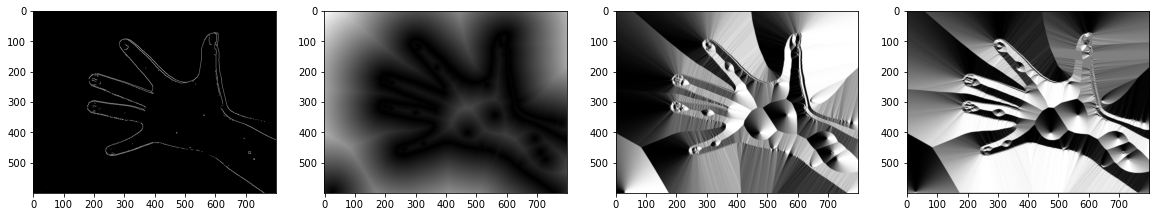

In [52]:
# hand_landmarks.txt adjusted because of stange format of the landmarsk for np textload
hand_landmarks = np.loadtxt("data/hand_landmarks.txt")
hand_img = cv.imread("./data/hand.jpg")

E = compute_E(hand_img)
D = compute_D(E)
Gx, Gy = compute_G(D)
wx, wy = compute_w(hand_img)
x = correspondences(wx, wy, E, D, Gx, Gy)
affine_landmarks = fit_affine_trans_shape(hand_landmarks)


_, ax = plt.subplots(1, 4, figsize=(20,5))
ax[0].imshow(E, cmap="gray")
ax[1].imshow(D, cmap="gray")
ax[2].imshow(Gx, cmap="gray")
ax[3].imshow(Gy, cmap="gray")
plt.show()

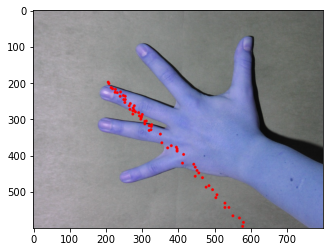

In [53]:
# swap landmark position because least squares is x, y, 0, 0 ...
icp(hand_img, 1, hand_landmarks[:, (1, 0)])

Something is wrong with my icp implementation. I can't figure out what